# File and libraries

In [14]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_7_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Google Merch Shop"

# DSLabs functions

In [15]:
%run "scripts/dslabs_functions.py"


# Data functions

In [16]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [17]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample to test setup
    sample=0.005
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)

    
else:
    # data=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    data=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)
 
 
target='returning_user'
target_metric='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18170 entries, 0 to 18169
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   event_name                       18170 non-null  float64
 1   device_category                  18170 non-null  float64
 2   device_mobile_model_name         18170 non-null  float64
 3   device_operating_system          18170 non-null  float64
 4   device_operating_system_version  18170 non-null  float64
 5   device_language                  18170 non-null  float64
 6   device_web_info_browser          18170 non-null  float64
 7   device_web_info_browser_version  18170 non-null  float64
 8   geo_region                       18170 non-null  float64
 9   geo_city                         18170 non-null  float64
 10  traffic_source_medium            18170 non-null  float64
 11  traffic_source_source            18170 non-null  float64
 12  engagement_time_msec   

# Distribution Check

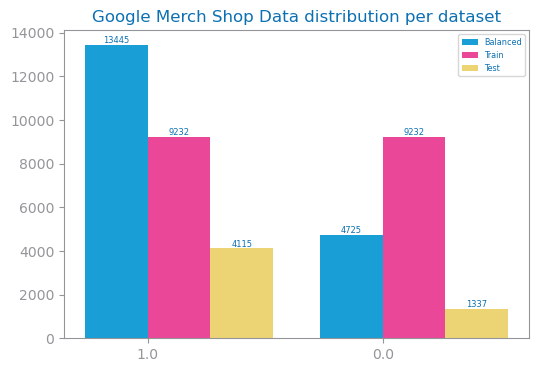

In [18]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title=f"{file_tag} Data distribution per dataset")
show()

# eval prep

In [19]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

Train#=18464 Test#=5452
Labels=[0.0, 1.0]


In [20]:
max_iter_eval=2000
lag_eval=200

# f2 evaluate

## f2 study

In [ ]:

figure()

best_model_f2, f2_params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=max_iter_eval,
    lag=lag_eval,
    metric='f2',
    file_tag=file_tag
)
savefig(f"images/{file_tag}_mlp_{f2_params['metric']}_study.png")
show()

## f2 best model

<Figure size 640x480 with 0 Axes>

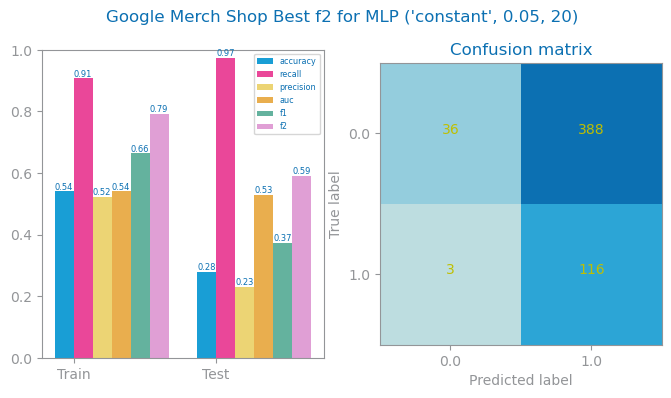

In [9]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
savefig(f'images/{file_tag}_mlp_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

## f2 Overfitting

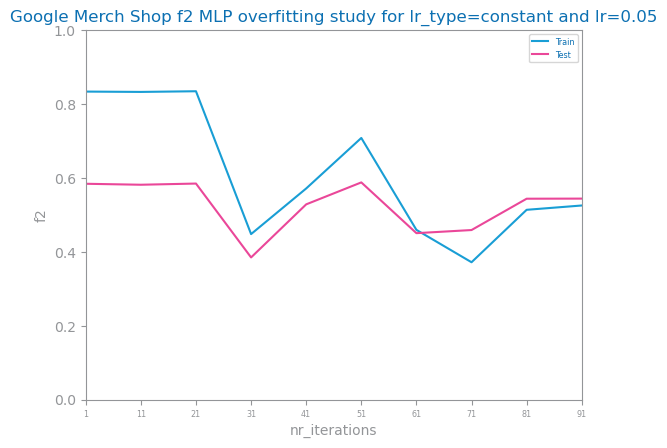

In [10]:
lr_type: Literal["constant", "invscaling", "adaptive"] = f2_params["params"][0]
lr: float = f2_params["params"][1]
nr_iterations: list[int] = [i for i in range(1, max_iter_eval, lag_eval)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = f2_params['metric']

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} {eval_metric} MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_mlp_{eval_metric}_overfitting.png")

# precision evaluate

## precision study

MLP best for 10 iterations (lr_type=invscaling and lr=0.05


<Figure size 640x480 with 0 Axes>

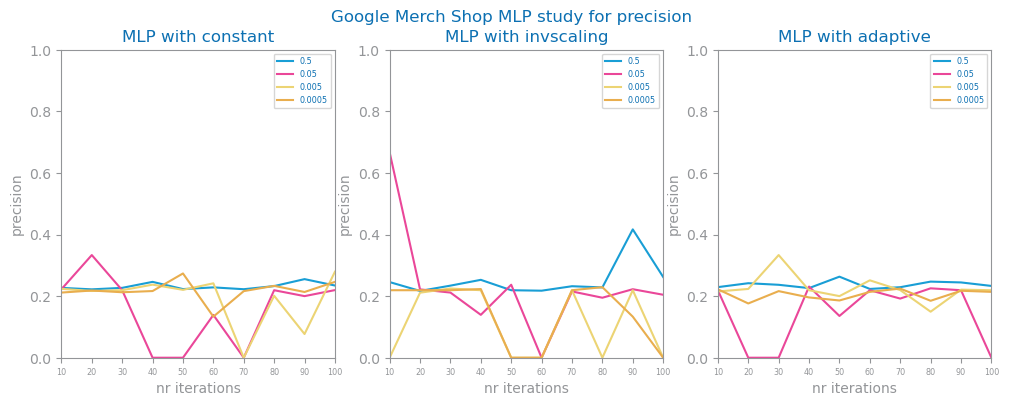

In [11]:

figure()

best_model_prec, prec_params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=max_iter_eval,
    lag=lag_eval,
    metric='precision',
    file_tag=file_tag
)
savefig(f"images/{file_tag}_mlp_{prec_params['metric']}_study.png")
show()

## precision best model

<Figure size 640x480 with 0 Axes>

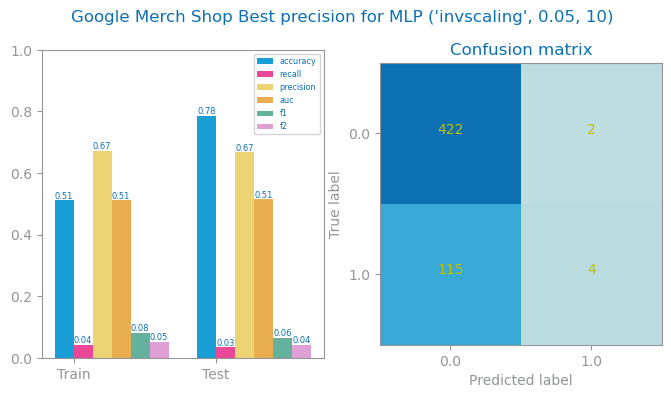

In [12]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag)
savefig(f'images/{file_tag}_mlp_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

## precision overfitting

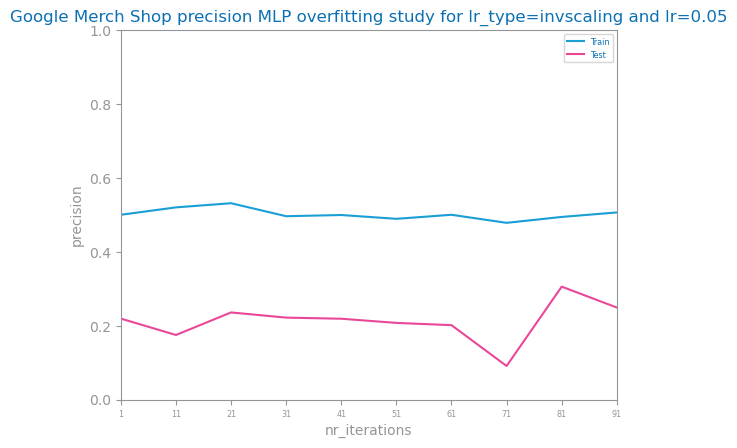

In [13]:
lr_type: Literal["constant", "invscaling", "adaptive"] = prec_params["params"][0]
lr: float = prec_params["params"][1]
nr_iterations: list[int] = [i for i in range(1, max_iter_eval, lag_eval)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = prec_params['metric']

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} {eval_metric} MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_mlp_{eval_metric}_overfitting.png")

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
